In [24]:
import tenpy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

#load the data
#measurements (values of dictionnary)
meas_key_list=['energy_MPO', 'scalar_chirality', 'entropy', 'z', 'mp', 'pm', 'zz',
               'correlation_length', "eigs_tm", "01ij", "singular_values", 'zz_nn', 'mp_nn', 'pm_nn'] 
#the last keys: the 5 largest eigenvalues of the transfer matrix for sector of charge 0 ($\sum_i s_i^z=0$)

#simulation parameters 
nbSites_list=[6] #nb of sites per Ring (1st index of dictionnary)
chi_list=[50,100,150,250]#[1,100,150,200,300,400, 550,600,650,700] (2nd index of dictionnary) #
N_nbSites=len(nbSites_list)
N_chi=len(chi_list)
Ly=3

#phase diagram parameter (3rd index of dic)
theta_list=np.linspace(0,np.pi,21)
N_theta=len(theta_list)

#initialize data structure
meas_dic={}
for key in meas_key_list:
    meas_dic[key]=[[] for i in range(N_nbSites)]
for nbSites_idx in range(N_nbSites):
    for chi_idx in range(N_chi):
        with open('results/measur_dic_nbLegs3_nbRings%d_chi%s.pkl'%(nbSites_list[nbSites_idx], chi_list[chi_idx]), 'rb') as f:
            dic=pickle.load(f)
            for key in meas_key_list:
                meas_dic[key][nbSites_idx].append(dic[key])

#compute FT of <S0*Sr>
meas_dic['strFactor']=[[[] for j in range(N_chi)] for i in range(N_nbSites)]
a1=np.array([1,0]) #bravais vectors
a2=np.array([0.5, 3**0.5/2])
b1=np.array([1, -1/3**0.5]) #reciprocal vectors
b2=np.array([0, 2/3**0.5])
for nbSites_idx in range(N_nbSites):
    for chi_idx in range(N_chi):
        for theta_idx in range(N_theta):
            N1=int(100//nbSites_list[nbSites_idx]) #number of sites along the axis (along the 1st bravais vector)
            N2=Ly #number of sites in the circonference (along the 2nd bravais vector)
            S=[[0 for j in range(N2)] for i in range(N1)]
            for k1_idx in range(N1): 
                for k2_idx in range(N2): #select a k
                    k=(2*np.pi*k1_idx/N1)*b1+(2*np.pi*k2_idx/N2)*b2
                    for idx1_1 in range(N1):
                        for idx1_2 in range(N2): 
                            idx1=idx1_1*N2+idx1_2
                            pos1=idx1_1*a1+idx1_2*a2 #vector between spin1 and spin2
                            ss=(meas_dic['zz'][nbSites_idx][chi_idx][theta_idx][0][idx1]
                                +0.5*(meas_dic['pm'][nbSites_idx][chi_idx][theta_idx][0][idx1]
                                                        +meas_dic['mp'][nbSites_idx][chi_idx][theta_idx][0][idx1]))
                            S[k1_idx][k2_idx]+=ss*np.exp(-1j*(np.dot(pos1, k)))
            meas_dic['strFactor'][nbSites_idx][chi_idx].append(S)

#compute nnematic order parameter according PRB95,035141 (2017): (=check for colinear states)
meas_dic['nematic']=[[[] for j in range(N_chi)] for i in range(N_nbSites)]
for nbSites_idx in range(N_nbSites):
    for chi_idx in range(N_chi):
        for JOnJx_idx in range(N_theta):
            nematic=0
            for shift in range(len(meas_dic['01ij'][nbSites_idx][chi_idx][theta_idx])): #meas_dic contains <(S0S1)(S2S3)>, <(S0S1)(S3S4)>,... Attention (S0S1)(S5S6),(S0S1)(S11S12),.. to remove  
                if((shift-3)%5!=0):
                    nematic+=meas_dic['01ij'][nbSites_idx][chi_idx][JOnJx_idx][shift]
            meas_dic['nematic'][nbSites_idx][chi_idx].append(nematic)

#compute structure factor from correlation functions
meas_dic['strFactor']=[[[] for j in range(N_chi)] for i in range(N_nbSites)]
a1=np.array([1,0]) #bravais vectors
a2=np.array([0.5, 3**0.5/2])
b1=np.array([1, -1/3**0.5]) #reciprocal vectors
b2=np.array([0, 2/3**0.5])
for nbSites_idx in range(N_nbSites):
    for chi_idx in range(N_chi):
        for JOnJx_idx in range(N_para):
            N1=int(300//nbSites_list[nbSites_idx]) #number of sites along the axis (along the 1st bravais vector)
            N2=nbSites_list[nbSites_idx] #number of sites in the circonference (along the 2nd bravais vector)
            S=[[0 for j in range(N2)] for i in range(N1)]
            for k1_idx in range(N1): 
                for k2_idx in range(N2): #select a k
                    k=(2*np.pi*k1_idx/N1)*b1+(2*np.pi*k2_idx/N2)*b2
                    for idx1_1 in range(N1):
                        for idx1_2 in range(N2): 
                            idx1=idx1_1*N2+idx1_2
                            pos1=idx1_1*a1+idx1_2*a2
                            for idx2_1 in range(N1):
                                for idx2_2 in range(N2): #compute the correlation function at idx1
                                    idx2=idx2_1*N2+idx2_2
                                    pos2=idx2_1*a1+idx2_2*a2
                                    ss=meas_dic['zz'][nbSites_idx][chi_idx][JOnJx_idx][idx1][idx2]+0.5*(meas_dic['pm'][nbSites_idx][chi_idx][JOnJx_idx][idx1][idx2]+meas_dic['mp'][nbSites_idx][chi_idx][JOnJx_idx][idx1][idx2])
                                    S[k1_idx][k2_idx]+=ss*np.exp(-1j*(np.dot(pos2-pos1, k)))
            meas_dic['strFactor'][nbSites_idx][chi_idx].append(S)

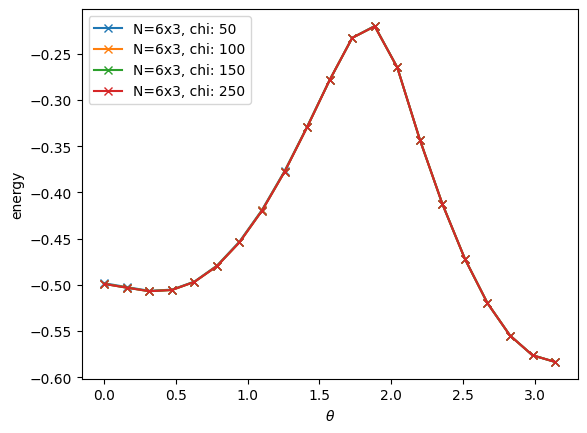

In [25]:
#plot total energy
nbSites_idx=0
plt.figure()
for chi_idx in range(N_chi): 
    plt.plot(np.array(theta_list), meas_dic['energy_MPO'][nbSites_idx][chi_idx],  marker='x', label="N=%dx3, chi: %d"%(nbSites_list[nbSites_idx], chi_list[chi_idx]))
plt.xlabel(r'$\theta$')
plt.ylabel('energy')
plt.legend()

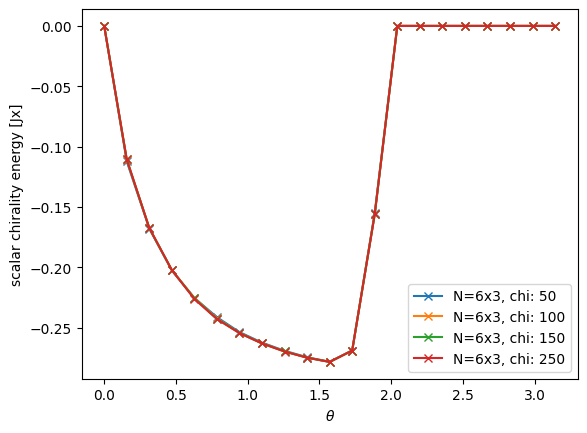

In [26]:
#plot chiral energy
plt.figure()
for chi_idx in range(N_chi): 
    plt.plot(np.array(theta_list), meas_dic['scalar_chirality'][0][chi_idx],  marker='x', label="N=%dx%d, chi: %d"%(nbSites_list[nbSites_idx],3, chi_list[chi_idx]))
plt.xlabel(r'$\theta$')
plt.ylabel('scalar chirality energy [Jx]')
plt.legend()

they might be a small intermediate gapped phase at theta=1.57-1.73 and at theta=0.4 if we look also at the correlation and similarly at about 0.4


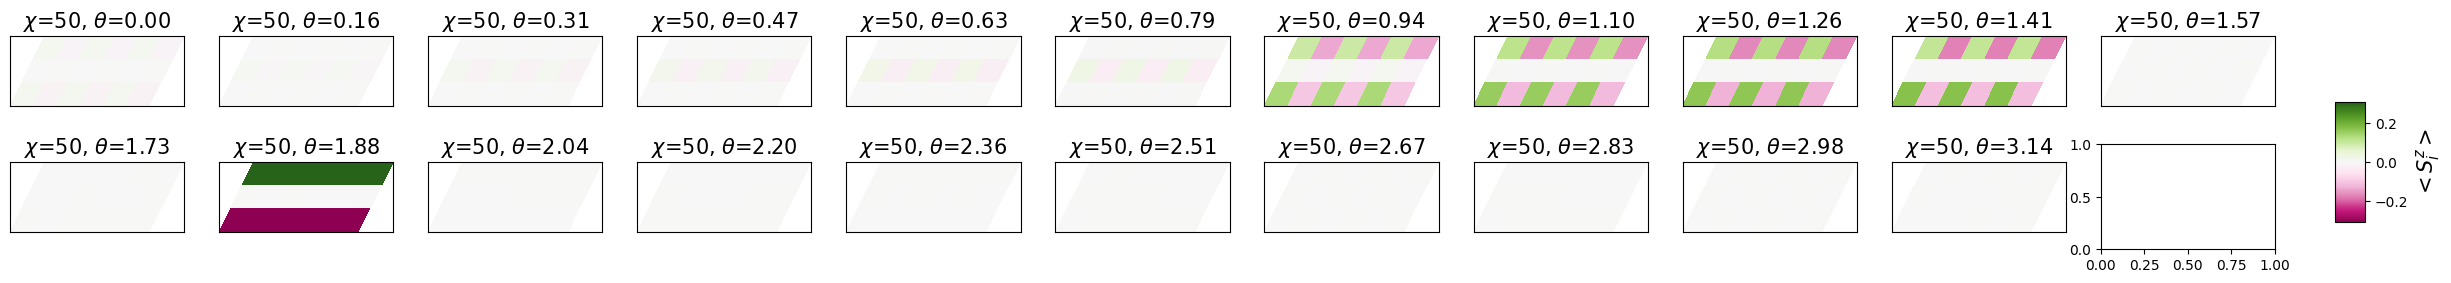

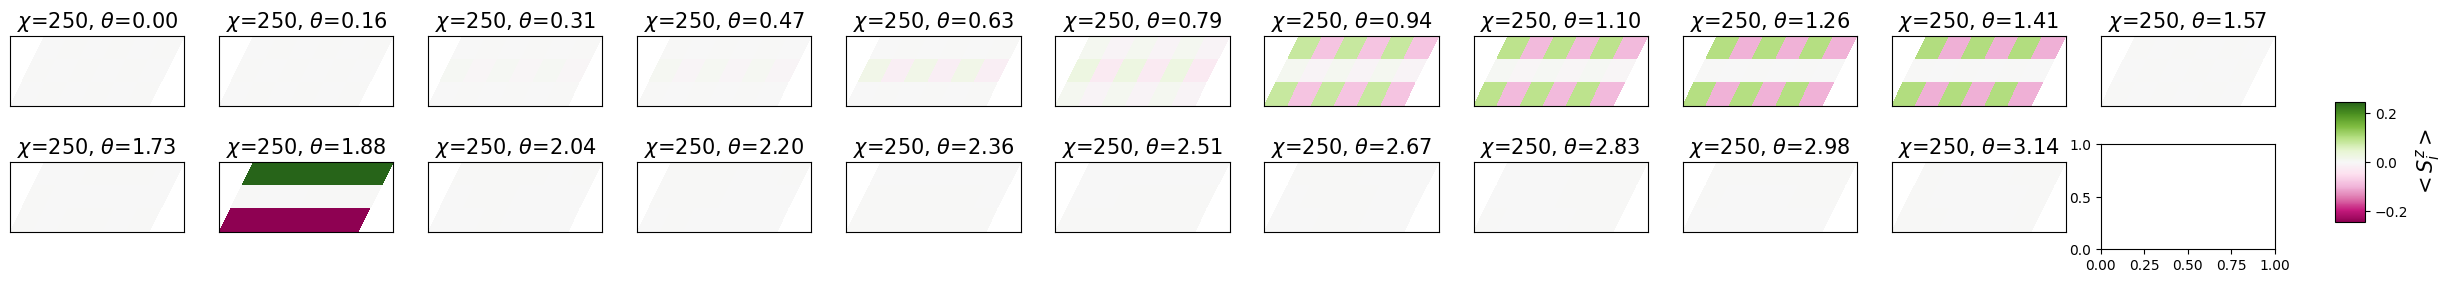

In [43]:
#plot on site expectation value
Ly=3
for chi_idx in [0,-1]:
    Lx=nbSites_list[nbSites_idx]
    X=np.zeros((Ly,Lx))
    Y=np.zeros((Ly,Lx))
    for i in range(Ly):
        for j in range(Lx):
            X[i,j]=j+0.5*i
            Y[i,j]=i
    idx_plot=0
    fig, axes = plt.subplots(nrows=2, ncols=11,  figsize=(30, 3))
    vAbsMax=np.max(np.abs(np.array(meas_dic['z'][nbSites_idx][chi_idx][:21])))
    for sim_idx in range(21):
        axi=axes[idx_plot//11][idx_plot%11]
        idx_plot+=1
        Sz_space=[[meas_dic['z'][nbSites_idx][chi_idx][sim_idx][x][y] for x in range(Lx)] 
                  for y in range(Ly)]
        pcm = axi.pcolormesh(X,Y,Sz_space,cmap='PiYG', shading='nearest', vmin=-vAbsMax, vmax=vAbsMax)
        axi.set_aspect('equal', adjustable='box')
        # plot colorbar on the side
        axi.tick_params(
            which='both',    
            bottom=False,   
            top=False,
            left=False,
            labelleft=False, 
            labelbottom=False)
        axi.set_title(r'$\chi$=%d, $\theta$=%.2f'%(chi_list[chi_idx], theta_list[sim_idx]), fontsize=15)
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.2, 0.01, 0.4])
    cbar=fig.colorbar(pcm, cax=cbar_ax)
    cbar.set_label(r'$<S_i^z>$', fontsize=15)

print("they might be a small intermediate gapped phase at theta=1.57-1.73 and at theta=0.4 if we look also at the correlation and similarly at about 0.4")

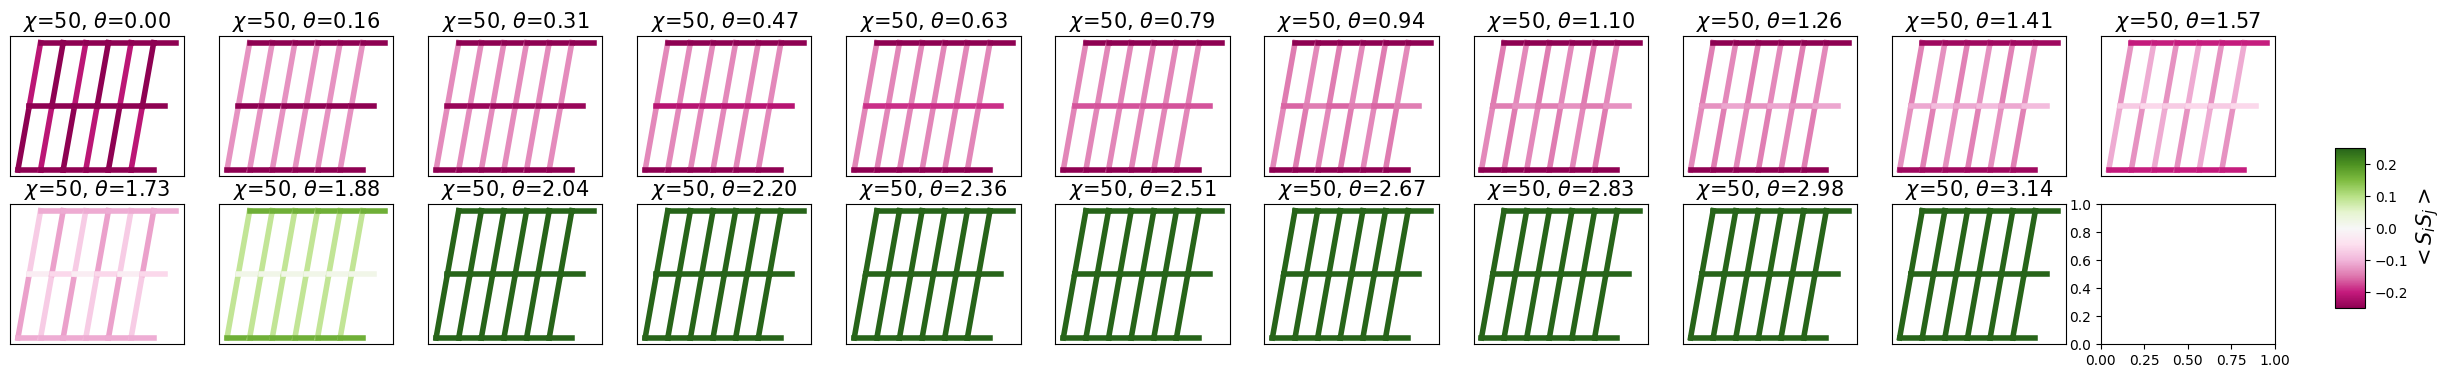

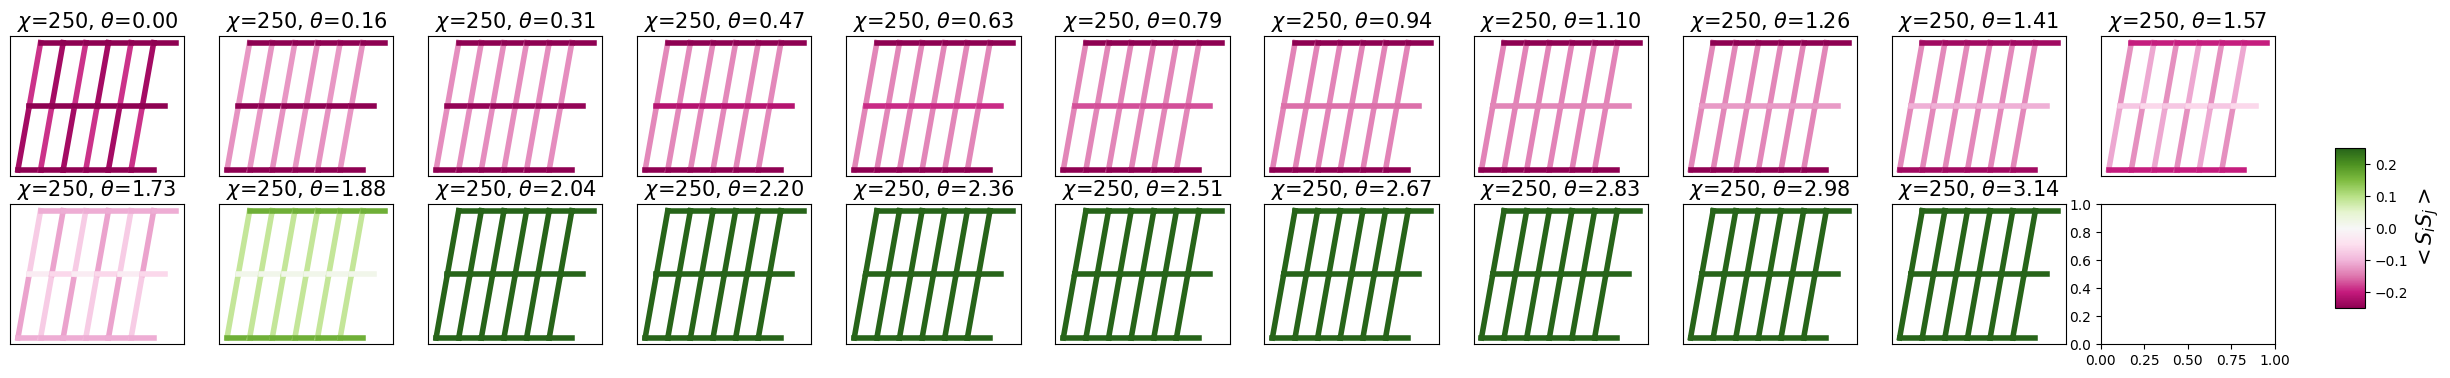

In [28]:
#plot bond energy
Ly=3
for chi_idx in [0,-1]:
    N=Ly*nbSites_list[nbSites_idx]
    fig, axes = plt.subplots(nrows=2, ncols=11, figsize=(30, 4))
    idx_plot=0
    vAbsMax=np.max(np.real(np.array(meas_dic['zz_nn'][nbSites_idx][chi_idx][sim_idx])+
                                 0.5*np.array(meas_dic['pm_nn'][nbSites_idx][chi_idx][sim_idx])+
                                 0.5*np.array(meas_dic['pm_nn'][nbSites_idx][chi_idx][sim_idx])))
    norm = mpl.colors.Normalize(vmin=-vAbsMax, vmax=vAbsMax)
    for sim_idx in range(21):
        axi=axes[idx_plot//11][idx_plot%11]
        idx_plot+=1

        colors = plt.cm.PiYG(norm(np.real(np.array(meas_dic['zz_nn'][nbSites_idx][chi_idx][sim_idx])+
                                 0.5*np.array(meas_dic['pm_nn'][nbSites_idx][chi_idx][sim_idx])+
                                 0.5*np.array(meas_dic['pm_nn'][nbSites_idx][chi_idx][sim_idx]))))
        for i in range(N):
            if((i%Ly)+1<Ly):
                axi.plot([i//Ly+0.5*(i%Ly),i//Ly+0.5*(i%Ly+1)],[i%Ly, (i+1)%Ly], color=colors[i][0], linewidth=4) #element on next leg
            axi.plot([i//Ly+0.5*(i%Ly),i//Ly+0.5*(i%Ly)+1],[i%Ly, i%Ly], color=colors[i][1], linewidth=4) #element on the right
        axi.set_title(r'$\chi$=%d, $\theta$=%.2f'%(chi_list[chi_idx],theta_list[sim_idx]), fontsize=15)
        axi.tick_params(
            which='both',    
            bottom=False,   
            top=False,
            left=False,
            labelleft=False, 
            labelbottom=False)
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.90, 0.2, 0.01, 0.4])
    cmap=plt.cm.PiYG
    cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
    cbar.set_label(r'$<S_iS_j>$', fontsize=15)

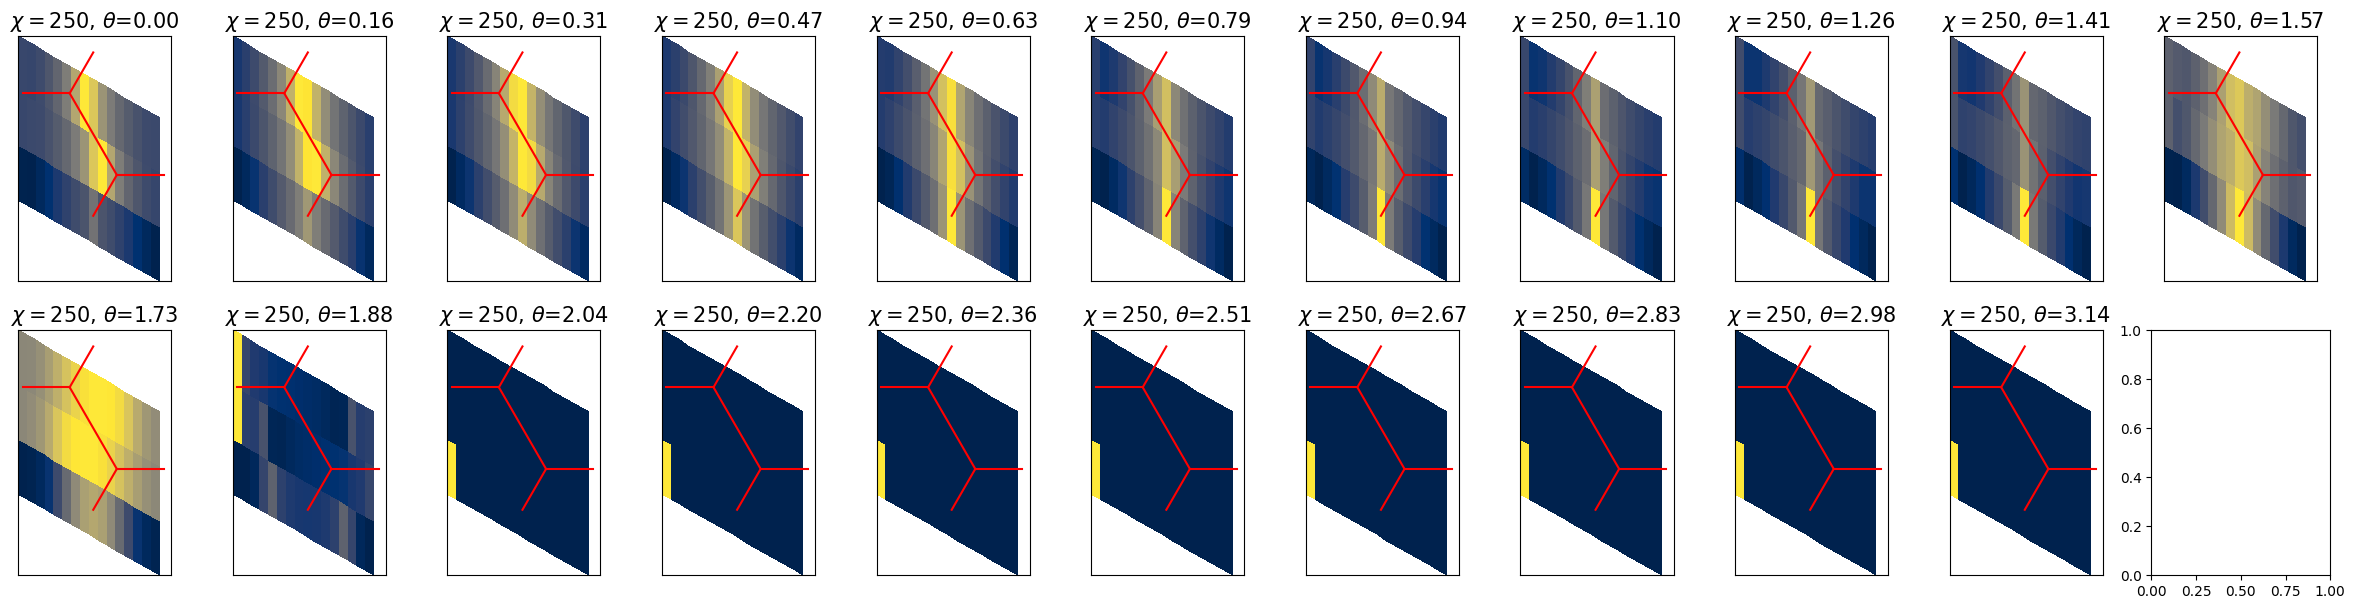

In [30]:
#plot structure factor
chi_idx=-1
for nbSites_idx in range(N_nbSites):
    idx_plot=0
    fig, axes = plt.subplots(nrows=2, ncols=11, figsize=(30, 7))
    max_value=np.max(np.abs(meas_dic['strFactor'][nbSites_idx][chi_idx]))
    for theta_idx in range(N_theta):
        N1=int(100//nbSites_list[nbSites_idx]) #number of sites along the axis
        N2=Ly #number of sites in the circonference (along the 2nd bravais vector)
        S=[[0 for j in range(N2)] for i in range(N1)]
        X=np.zeros((N1,N2))
        Y=np.zeros((N1,N2))
        for k1_idx in range(N1):
            for k2_idx in range(N2):
                k=(2*np.pi*k1_idx/N1)*b1+(2*np.pi*k2_idx/N2)*b2
                X[k1_idx,k2_idx]=k[0]
                Y[k1_idx,k2_idx]=k[1]
        axi=axes[idx_plot//11][idx_plot%11]
        idx_plot+=1
        pcm = axi.pcolormesh(X,Y,np.abs(meas_dic['strFactor'][nbSites_idx][chi_idx][theta_idx]),cmap='cividis', shading='nearest')
        axi.set_aspect('equal', adjustable='box')
        #axi.tick_params(axis='both', which='major', labelsize=0)
        axi.plot([0, 2*np.pi/3],[2*np.pi/3**0.5,2*np.pi/3**0.5], color='red')
        axi.plot([2*np.pi/3, np.pi],[2*np.pi/3**0.5,3*np.pi/3**0.5], color='red')
        axi.plot([2*np.pi/3,4*np.pi/3],[2*np.pi/3**0.5,0], color='red')
        axi.plot([4*np.pi/3,2*np.pi],[0,0], color='red')
        axi.plot([4*np.pi/3,np.pi],[0,-np.pi/3**0.5], color='red')
        # plot colorbar on the side
        axi.tick_params(
            which='both',    
            bottom=False,   
            top=False,
            left=False,
            labelleft=False, 
            labelbottom=False)
        axi.set_title(r'$\chi=$%s, $\theta$=%.2f'%(chi_list[chi_idx], theta_list[theta_idx]), fontsize=15)

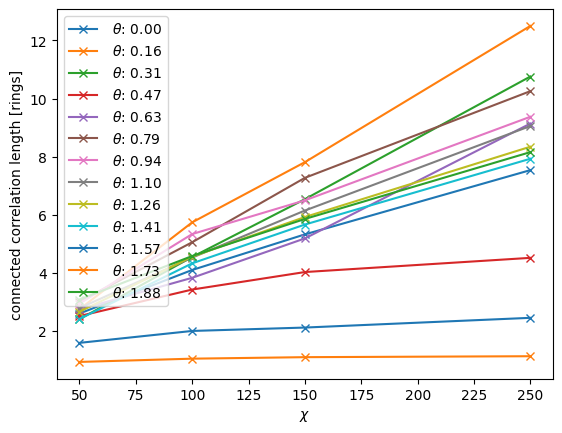

In [41]:
#plot correlation length in number of rings
for nbSites_idx in range(N_nbSites):
    plt.figure()
    for theta_idx in range(13): 
        plt.plot(chi_list, [meas_dic['correlation_length'][nbSites_idx][chi_idx][theta_idx] for chi_idx in range(N_chi)], marker='x', label=r" $\theta$: %.2f"%(theta_list[theta_idx]))
    plt.xlabel(r'$\chi$')
    plt.ylabel('connected correlation length [rings]')
    plt.legend()

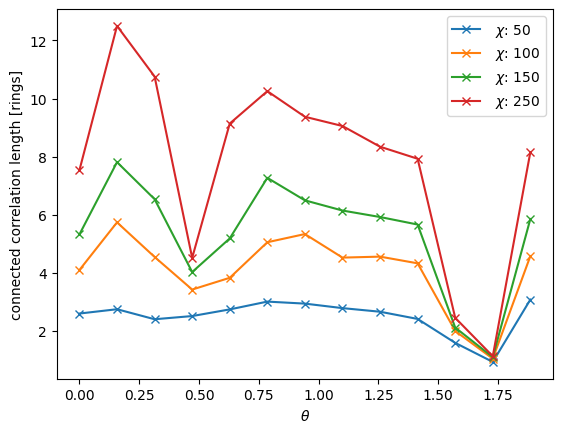

In [19]:
#plot correlation length as a function of theta
for nbSites_idx in range(N_nbSites):
    plt.figure()
    for chi_idx in range(N_chi): 
        plt.plot(theta_list[:13], [meas_dic['correlation_length'][nbSites_idx][chi_idx][theta_idx] for theta_idx in range(13)], marker='x', label=r" $\chi$: %d"%(chi_list[chi_idx]))
    plt.xlabel(r'$\theta$')
    plt.ylabel('connected correlation length [rings]')
    plt.legend()


for $\theta$=0.63, the slope is 0.30
for $\theta$=0.79, the slope is 0.52
for $\theta$=0.94, the slope is 0.59
for $\theta$=1.10, the slope is 0.59
for $\theta$=1.26, the slope is 0.61
for $\theta$=1.41, the slope is 0.62


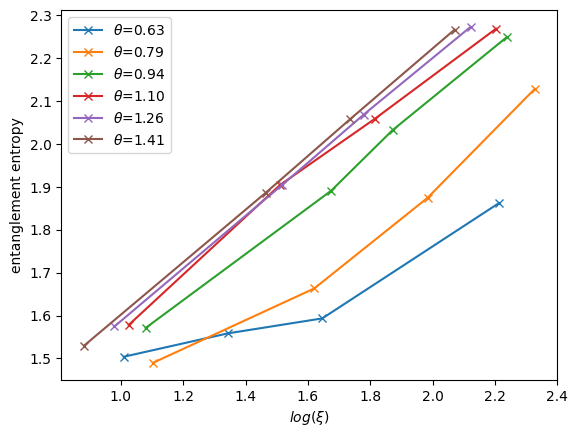

In [42]:
#plot entangelement entropy as a function of corellation
plt.figure()
for theta_idx in range(4,10):
    plt.plot(np.log([meas_dic['correlation_length'][nbSites_idx][chi_idx][theta_idx] for chi_idx in range(N_chi)]),[meas_dic['entropy'][nbSites_idx][chi_idx][theta_idx][0] for chi_idx in range(N_chi)],  marker='x',label=r'$\theta$=%.2f'%theta_list[theta_idx])
    plt.xlabel(r'$log(\xi)$')
    plt.ylabel(r'entanglement entropy')
    plt.legend()

    #compute slopes
    x1=np.log([meas_dic['correlation_length'][nbSites_idx][chi_idx][theta_idx] for chi_idx in range(N_chi)])[0]
    x2=np.log([meas_dic['correlation_length'][nbSites_idx][chi_idx][theta_idx] for chi_idx in range(N_chi)])[-1]
    y1=[meas_dic['entropy'][nbSites_idx][chi_idx][theta_idx][0] for chi_idx in range(N_chi)][0]
    y2=[meas_dic['entropy'][nbSites_idx][chi_idx][theta_idx][0] for chi_idx in range(N_chi)][-1]
    print(r'for $\theta$=%.2f, the slope is %.2f'%(theta_list[theta_idx], (y2-y1)/(x2-x1)))

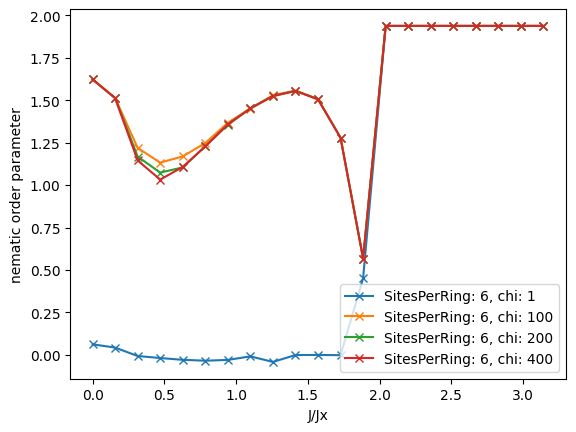

In [ ]:
#plot nematic order parameter
for nbSites_idx in range(N_nbSites):
    plt.figure()
    for chi_idx in range(N_chi): 
        plt.plot(np.array(theta_list), meas_dic['nematic'][nbSites_idx][chi_idx], marker='x', label="SitesPerRing: %d, chi: %s"%(nbSites_list[nbSites_idx], chi_list[chi_idx]))
    plt.xlabel('J/Jx')
    plt.ylabel('nematic order parameter')
    plt.legend()
    
#below 1, it is not a colinear order... (for 36 sites)

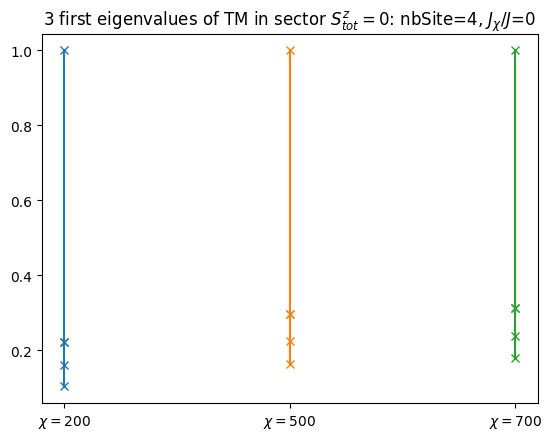

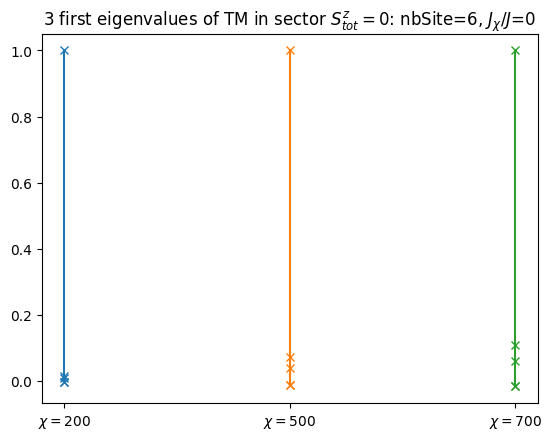

In [16]:
#plot spectrum of transfer matrix at JOnJx=0
for nbSites_idx in range(N_nbSites):
    plt.figure()
    plt.plot([r'$\chi=%s$'%chi_list[0]]*5, np.real(meas_dic['eigs_tm'][nbSites_idx][0][0][[0,1,2,3,4]]),  marker='x')
    plt.plot([r'$\chi=%s$'%chi_list[1]]*5, np.real(meas_dic['eigs_tm'][nbSites_idx][1][0][[0,1,2,3,4]]),  marker='x')
    plt.plot([r'$\chi=%s$'%chi_list[2]]*5, np.real(meas_dic['eigs_tm'][nbSites_idx][2][0][[0,1,2,3,4]]),  marker='x')
    plt.title(r"3 first eigenvalues of TM in sector $S_{tot}^z=0$: nbSite=%d, $J_{\chi}/J$=0"%nbSites_list[nbSites_idx])

#we have not at all converged in terms of correlation length!!!!! the distance between 3rd and 2nd eigenvalue increases

In the 5 first eigenvalues for the complete spectrum (not just in the zero charge sector), the 2nd eigenvalue is a triplet.

the predicted correlation length is 1.42 rings
the predicted correlation length is 0.39 rings


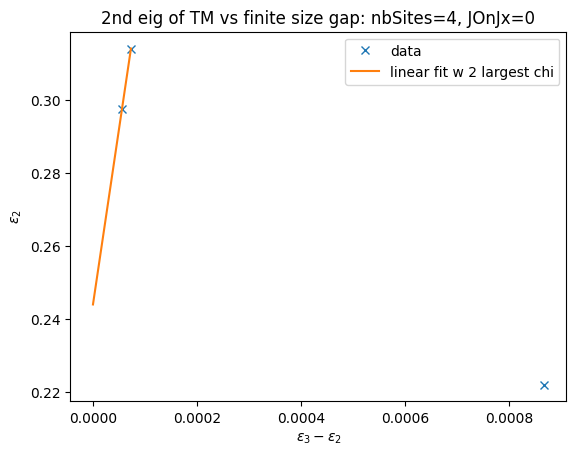

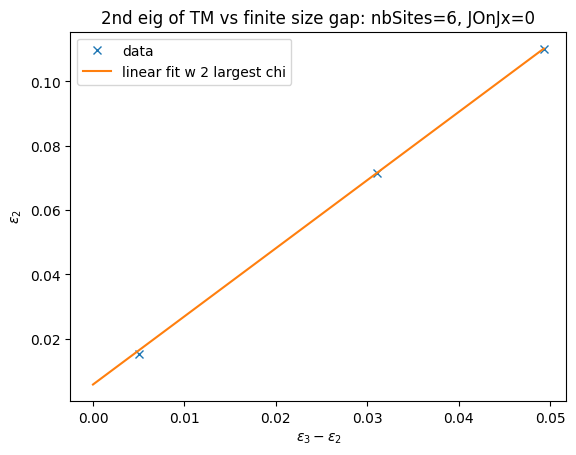

In [17]:
#predict correlation length (using 2nd and 3rd eigenvalue of TM spectrum for charge=0) at JOnJx=0
for nbSites_idx in range(N_nbSites):
    delta_list=np.real([meas_dic['eigs_tm'][nbSites_idx][chi_idx][0][1]-meas_dic['eigs_tm'][nbSites_idx][chi_idx][0][2] for chi_idx in range(0,3)])
    secndEig_list= np.real([meas_dic['eigs_tm'][nbSites_idx][chi_idx][0][1] for chi_idx in range(0,3)])
    slope=(secndEig_list[2]-secndEig_list[1])/(delta_list[2]-delta_list[1])
    offset=secndEig_list[2]-slope*delta_list[2]

    plt.figure()
    plt.plot(delta_list, secndEig_list,  marker='x', label='data', linestyle='')
    deltaFit_list=np.array([0, delta_list[2]])
    plt.plot(deltaFit_list, offset+slope*deltaFit_list, label='linear fit w 2 largest chi')
    plt.legend()
    plt.xlabel(r'$\varepsilon_3-\varepsilon_2$')
    plt.ylabel(r'$\varepsilon_2$')
    plt.title('2nd eig of TM vs finite size gap: nbSites=%d, JOnJx=0'%nbSites_list[nbSites_idx])
    print("the predicted correlation length is %1.2f rings"%(-2/np.log(np.real(offset))))

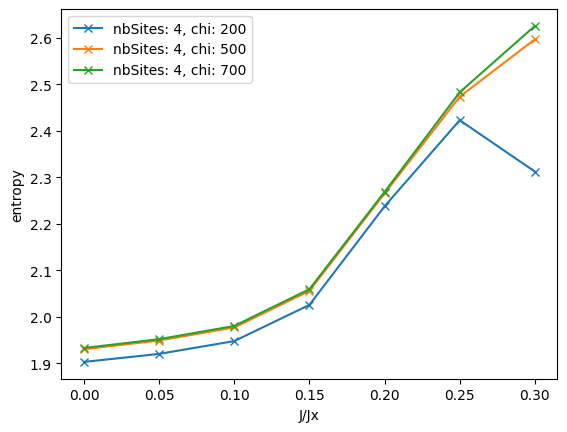

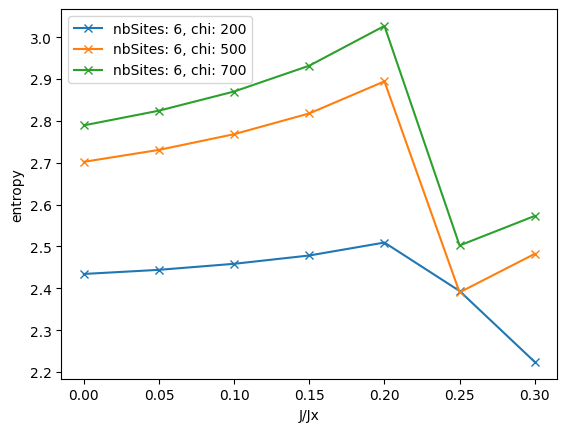

In [18]:
#plot von Neuman entropy at half cilynder
for nbSites_idx in range(N_nbSites):
    plt.figure()
    for chi_idx in range(N_chi): 
        plt.plot(np.array(JOnJx_list),  [meas_dic['entropy'][nbSites_idx][chi_idx][i][nbSites_list[nbSites_idx]-1] for i in range(len(JOnJx_list))],  marker='x', label="nbSites: %d, chi: %s"%(nbSites_list[nbSites_idx],chi_list[chi_idx]))
    plt.xlabel('J/Jx')
    plt.ylabel('entropy')
    plt.legend()

-ln(2) is:  -0.6931471805599453


/tmp/ipykernel_616/3151010448.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


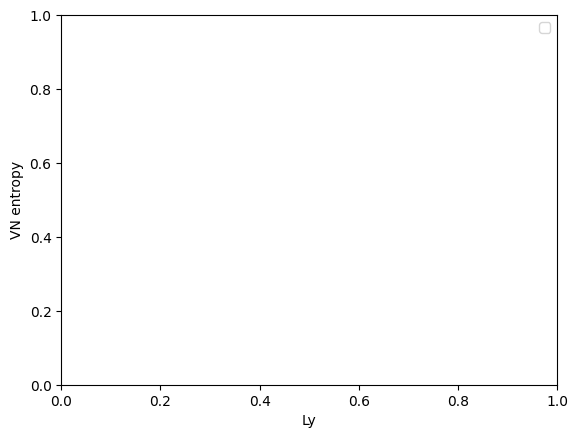

In [19]:
#finite entanglement entropy:  finite entanglement entropy
plt.figure()
chi_idx=-1
color_list=['blue', 'purple', 'red', 'orange']
for idx_JOnJx in range(7,N_para):
    plt.plot([nbSites_list[nbSites_idx] for nbSites_idx in range(N_nbSites)], [meas_dic['entropy'][nbSites_idx][chi_idx][idx_JOnJx][nbSites_list[nbSites_idx]-1] for nbSites_idx in range(N_nbSites)],  marker='x',label="JOnJx: %.1f"%JOnJx_list[idx_JOnJx], color=color_list[idx_JOnJx-7])
    slope=(meas_dic['entropy'][1][chi_idx][idx_JOnJx][nbSites_list[1]-1]-meas_dic['entropy'][0][chi_idx][idx_JOnJx][nbSites_list[0]-1])/2
    offset=meas_dic['entropy'][1][chi_idx][idx_JOnJx][nbSites_list[1]-1]-slope*nbSites_list[nbSites_idx]
    entangFit_list=np.array([0, 6])
    plt.plot(entangFit_list, offset+slope*entangFit_list, color=color_list[idx_JOnJx-7])
    print('topological entanglement entropy for JOnJx=%1.f : %1.3f'%(JOnJx_list[idx_JOnJx], offset))
plt.xlabel("Ly")
plt.ylabel('VN entropy')
plt.legend()
print('-ln(2) is: ', -np.log(2))

